# ДЗ 6


In [1]:
!pip install implicit

     |████████████████████████████████| 1.1MB 18.8MB/s 
  Created wheel for implicit: filename=implicit-0.4.4-cp36-cp36m-linux_x86_64.whl size=3419418 sha256=d352c59ef55472526ca4531fd5127327583f964199f7a5e996c4ee02042d1afe
  Stored in directory: /root/.cache/pip/wheels/bf/d4/ec/fd4f622fcbefb7521f149905295b2c26adecb23af38aa28217
Successfully built implicit


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!cp -R  /content/drive/MyDrive/Recomendation/srcrec  /

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Написанные нами функции
from srcrec.metrics import precision_at_k, recall_at_k
from srcrec.utils import prefilter_items
from srcrec.recommenders import MainRecommender

In [5]:
import random

In [6]:
base_path = "/content/drive/MyDrive/Recomendation/"

data = pd.read_csv(base_path+'retail_train.csv')
item_features = pd.read_csv(base_path+'product.csv')
user_features = pd.read_csv(base_path+'hh_demographic.csv')

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)

# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)
val_lvl_1_size_weeks = 6
val_lvl_2_size_weeks = 3

data_train_lvl_1 = data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)]
data_val_lvl_1 = data[(data['week_no'] >= data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)) &
                      (data['week_no'] < data['week_no'].max() - (val_lvl_2_size_weeks))]

data_train_lvl_2 = data_val_lvl_1.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться
data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

data_train_lvl_1.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [7]:
n_items_before = data_train_lvl_1['item_id'].nunique()

data_train_lvl_1 = prefilter_items(data_train_lvl_1, item_features)

n_items_after = data_train_lvl_1['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 83685 to 3790


In [8]:
recommender = MainRecommender(data_train_lvl_1, item_features)

GPU training requires factor size to be a multiple of 32. Increasing factors from 20 to 32.


In [9]:
item_list = data_train_lvl_1.loc[data_train_lvl_1["item_id"] != 999999, "item_id"].unique()
item_list[:10]

array([ 950384, 1077373,  839040,  854483,  892314,  930666,  948254,
        957411, 1007549, 1044089])

In [10]:
recommender.get_als_recommendations(2375, rec_num=5)

[899624, 9835223, 823990, 821083, 925862]

In [11]:
recommender.get_own_recommendations(2375, rec_num=5)

[1036501, 907099, 1085983, 1079023, 910439]

In [12]:
recommender.get_similar_items_recommendation(2375, rec_num=5)

[9527494, 899624, 989069, 1079023, 1036501]

In [13]:
recommender.get_similar_users_recommendation(2375, rec_num=5)

[925862, 935284, 12731544, 1056509, 932863]

In [14]:
result_lvl_1 = data_val_lvl_1.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_1.columns=['user_id', 'actual']
result_lvl_1.head()

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."
2,4,"[883932, 970760, 1035676, 1055863, 1097610, 67..."
3,6,"[1024306, 1102949, 6548453, 835394, 940804, 96..."
4,7,"[836281, 843306, 845294, 914190, 920456, 93886..."


### Задание 1

A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 50 кандидатов (k=50)
- Качество измеряем на data_val_lvl_1: следующие 6 недель после трейна

Дают ли own recommendtions + top-popular лучший recall?  

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  
C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?


#### get_als_recommendations

In [15]:
users_lvl_1_pred_als = pd.DataFrame(data_val_lvl_1['user_id'].unique())
users_lvl_1_pred_als.columns = ['user_id']
users_lvl_1_pred_als.head()

,user_id
0,2070
1,2021
2,1753
3,2120
4,1346


In [16]:
recommender.get_als_recommendations(2120, rec_num=7)

[989824, 1110843, 1062002, 1043301, 927291, 995055, 837270]

In [17]:
user_train_list = data_train_lvl_1["user_id"].unique().tolist()

In [18]:
1984 in user_train_list

False

In [19]:
def get_pred_als(recommender, user_train_list, item_list, x, num=7):
    res = []
    if x in user_train_list:
        res.extend(recommender.get_als_recommendations(x, rec_num=num))
    else:
        res.extend(random.choices(item_list, k=num))
    return res

In [20]:
get_pred_als(recommender, user_train_list, item_list, 2120, num=7)

[989824, 1110843, 1062002, 1043301, 927291, 995055, 837270]

In [21]:
get_pred_als(recommender, user_train_list, item_list, 1984, num=7)

[1048563, 8291322, 1000753, 826272, 903350, 1019883, 958826]

In [22]:
users_lvl_1_pred_als['predictions'] = users_lvl_1_pred_als['user_id'].apply(\
                            lambda x: get_pred_als(recommender, user_train_list, item_list, x, num=7))
users_lvl_1_pred_als.head()

,user_id,predictions
0,2070,"[896085, 896369, 1107553, 9527290, 1073150, 95..."
1,2021,"[12731544, 998556, 969866, 969205, 896862, 101..."
2,1753,"[991951, 862981, 13842224, 859237, 901543, 860..."
3,2120,"[989824, 1110843, 1062002, 1043301, 927291, 99..."
4,1346,"[9419443, 1105488, 901666, 965267, 941361, 903..."


In [23]:
data_val_lvl_1[data_val_lvl_1["user_id"] == 2021][:5]

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
2107468,2021,40618753059,594,840361,1,0.99,443,0.00,101,86,0.0,0.0
2107469,2021,40618753059,594,856060,1,1.77,443,-0.09,101,86,0.0,0.0
2107470,2021,40618753059,594,869344,1,1.67,443,-0.22,101,86,0.0,0.0
2107471,2021,40618753059,594,896862,2,5.00,443,-2.98,101,86,0.0,0.0
2107472,2021,40618753059,594,951590,1,1.69,443,-0.60,101,86,0.0,0.0


In [24]:
users_lvl_1_pred_als.loc[users_lvl_1_pred_als["user_id"] == 2021, "predictions"].values[0]

[12731544, 998556, 969866, 969205, 896862, 1019142, 871756]

In [25]:
list(result_lvl_1.loc[result_lvl_1["user_id"] == 2021, "actual"].values[0])[:7]

[840361, 856060, 869344, 896862, 951590, 1019142, 1051489]

In [26]:
recall_at_k(users_lvl_1_pred_als.loc[users_lvl_1_pred_als["user_id"] == 2021, "predictions"].values[0], 
            list(result_lvl_1.loc[result_lvl_1["user_id"] == 2021, "actual"].values[0]), 
            k=7)

0.05714285714285714

In [27]:
users_lvl_1_pred_als["rec"] = users_lvl_1_pred_als['user_id'].apply(\
        lambda x: recall_at_k(users_lvl_1_pred_als.loc[users_lvl_1_pred_als["user_id"] == x, "predictions"].values[0], 
                              list(result_lvl_1.loc[result_lvl_1["user_id"] == x, "actual"].values[0]), 
                              k=7))
users_lvl_1_pred_als.head()

,user_id,predictions,rec
0,2070,"[896085, 896369, 1107553, 9527290, 1073150, 95...",0.006410
1,2021,"[12731544, 998556, 969866, 969205, 896862, 101...",0.057143
2,1753,"[991951, 862981, 13842224, 859237, 901543, 860...",0.024390
3,2120,"[989824, 1110843, 1062002, 1043301, 927291, 99...",0.000000
4,1346,"[9419443, 1105488, 901666, 965267, 941361, 903...",0.000000


In [28]:
users_lvl_1_pred_als["rec"].mean()

0.012324562416569505

In [29]:
k_list = [20, 50, 100, 200, 500, 750, 1000]

In [30]:
recall_als_list = []

for k_n in k_list:
    users_lvl_1_pred_als['predictions'] = users_lvl_1_pred_als['user_id'].apply(\
                            lambda x: get_pred_als(recommender, user_train_list, item_list, x, num=k_n))
    
    users_lvl_1_pred_als["rec"] = users_lvl_1_pred_als['user_id'].apply(\
        lambda x: recall_at_k(users_lvl_1_pred_als.loc[users_lvl_1_pred_als["user_id"] == x, "predictions"].values[0], 
                              list(result_lvl_1.loc[result_lvl_1["user_id"] == x, "actual"].values[0]), 
                              k=k_n))
    recall_als_list.append(users_lvl_1_pred_als["rec"].mean())

In [31]:
recall_als_list

[0.027643725257555263,
 0.051530718401298664,
 0.07888878884435496,
 0.11642180820027434,
 0.18059153688827895,
 0.2143593535700744,
 0.2395357898030196]

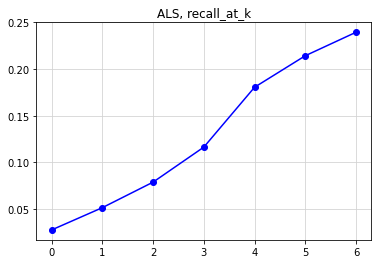

In [32]:
plt.plot(recall_als_list, 'bo-')

plt.grid(color="lightgrey")
plt.title('ALS, recall_at_k')
plt.show()

#### get_own_recommendations

In [33]:
def get_pred_own(recommender, user_train_list, item_list, x, num=7):
    res = []
    if x in user_train_list:
        res.extend(recommender.get_own_recommendations(x, rec_num=num))
    else:
        res.extend(random.choices(item_list, k=num))
    return res

In [34]:
recall_own_list = []

for k_n in k_list:
    users_lvl_1_pred_als['predictions'] = users_lvl_1_pred_als['user_id'].apply(\
                            lambda x: get_pred_own(recommender, user_train_list, item_list, x, num=k_n))
    
    users_lvl_1_pred_als["rec"] = users_lvl_1_pred_als['user_id'].apply(\
        lambda x: recall_at_k(users_lvl_1_pred_als.loc[users_lvl_1_pred_als["user_id"] == x, "predictions"].values[0], 
                              list(result_lvl_1.loc[result_lvl_1["user_id"] == x, "actual"].values[0]), 
                              k=k_n))
    recall_own_list.append(users_lvl_1_pred_als["rec"].mean())

recall_own_list

[0.0561290378255984,
 0.08471196249425086,
 0.11071884580165223,
 0.13421378374004725,
 0.14634029716954727,
 0.14675875479251876,
 0.14675875479251876]

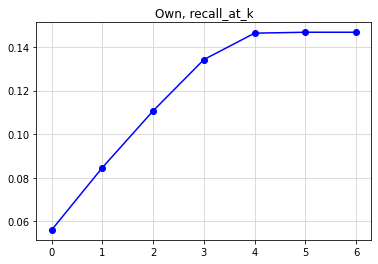

In [35]:
plt.plot(recall_own_list, 'bo-')

plt.grid(color="lightgrey")
plt.title('Own, recall_at_k')
plt.show()

#### get_similar_items_recommendation

In [36]:
def get_pred_similar_items(recommender, user_train_list, item_list, x, num=7):
    res = []
    if x in user_train_list:
        res.extend(recommender.get_similar_items_recommendation(x, rec_num=num))
    else:
        res.extend(random.choices(item_list, k=num))
    return res

In [37]:
recall_similar_items_list = []

for k_n in k_list:
    users_lvl_1_pred_als['predictions'] = users_lvl_1_pred_als['user_id'].apply(\
                            lambda x: get_pred_similar_items(recommender, user_train_list, item_list, x, num=k_n))
    
    users_lvl_1_pred_als["rec"] = users_lvl_1_pred_als['user_id'].apply(\
        lambda x: recall_at_k(users_lvl_1_pred_als.loc[users_lvl_1_pred_als["user_id"] == x, "predictions"].values[0], 
                              list(result_lvl_1.loc[result_lvl_1["user_id"] == x, "actual"].values[0]), 
                              k=k_n))
    recall_similar_items_list.append(users_lvl_1_pred_als["rec"].mean())

recall_similar_items_list

[0.06170210040688354,
 0.09313645629521643,
 0.11788380158356568,
 0.13770392811655813,
 0.14764610112055018,
 0.1478803750624087,
 0.14799643820075598]

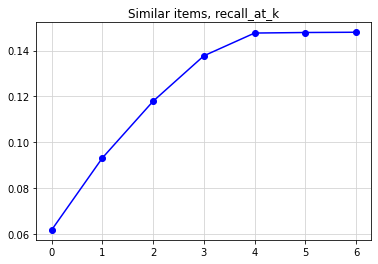

In [38]:
plt.plot(recall_similar_items_list, 'bo-')

plt.grid(color="lightgrey")
plt.title('Similar items, recall_at_k')
plt.show()

#### get_similar_users_recommendation

In [39]:
def get_pred_similar_users(recommender, user_train_list, item_list, x, num=7):
    res = []
    if x in user_train_list:
        res.extend(recommender.get_similar_users_recommendation(x, rec_num=num))
    else:
        res.extend(random.choices(item_list, k=num))
    return res

In [40]:
recall_similar_users_list = []

for k_n in k_list[:2]:
    users_lvl_1_pred_als['predictions'] = users_lvl_1_pred_als['user_id'].apply(\
                            lambda x: get_pred_similar_users(recommender, user_train_list, item_list, x, num=k_n))
    
    users_lvl_1_pred_als["rec"] = users_lvl_1_pred_als['user_id'].apply(\
        lambda x: recall_at_k(users_lvl_1_pred_als.loc[users_lvl_1_pred_als["user_id"] == x, "predictions"].values[0], 
                              list(result_lvl_1.loc[result_lvl_1["user_id"] == x, "actual"].values[0]), 
                              k=k_n))
    recall_similar_users_list.append(users_lvl_1_pred_als["rec"].mean())

recall_similar_users_list

[0.016030276584349572, 0.03197213268774982]

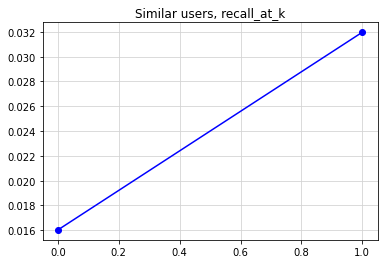

In [41]:
plt.plot(recall_similar_users_list, 'bo-')

plt.grid(color="lightgrey")
plt.title('Similar users, recall_at_k')
plt.show()

#### Выводы

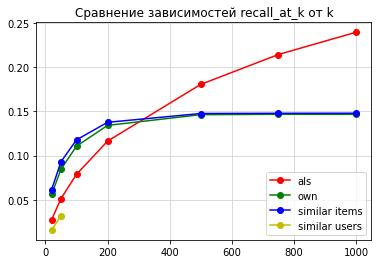

In [42]:
plt.plot(k_list, recall_als_list, 'ro-', label='als')
plt.plot(k_list, recall_own_list, 'go-', label='own')
plt.plot(k_list, recall_similar_items_list, 'bo-', label='similar items')
plt.plot(k_list[:2], recall_similar_users_list, 'yo-', label='similar users')

plt.legend(loc="lower right")
plt.grid(color="lightgrey")
plt.title('Сравнение зависимостей recall_at_k от k')
plt.show()

- Наибольшее значение recall показывает алгоритм ALS. 
- При увеличении к значение метрики нарастает до поределённого уровня насыщения. 
- При обработке дынных алгоритмом ALS не удалось установить уровень насыщения.
- При обработке данных алгоритмаи get own, similar items метрика достигает уровня насыщения на интервале значени k от 200 до 500.
- Строить зависимость метрики от k с помощью алгоритма similar users не лучшая затея.
- Для максимизации метрики recall необходимо использовать алгоритм ALS с максимальным значением k.

### Задание 2.

Обучите модель 2-ого уровня, при этом:
    - Добавьте минимум по 2 фичи для юзера, товара и пары юзер-товар
    - Измерьте отдельно precision@5 модели 1-ого уровня и двухуровневой модели на data_val_lvl_2
    - Вырос ли precision@5 при использовании двухуровневой модели?

In [43]:
users_lvl_2_pred_als = pd.DataFrame(data_val_lvl_2['user_id'].unique())
users_lvl_2_pred_als.columns = ['user_id']

In [44]:
result_lvl_2 = data_val_lvl_2.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_2.columns=['user_id', 'actual']

In [45]:
k_n = 5
users_lvl_2_pred_als['predictions'] = users_lvl_2_pred_als['user_id'].apply(\
                            lambda x: get_pred_als(recommender, user_train_list, item_list, x, num=20))
    
users_lvl_2_pred_als["rec"] = users_lvl_2_pred_als['user_id'].apply(\
        lambda x: precision_at_k(users_lvl_2_pred_als.loc[users_lvl_2_pred_als["user_id"] == x, "predictions"].values[0], 
                                 list(result_lvl_2.loc[result_lvl_2["user_id"] == x, "actual"].values[0]), 
                                 k=k_n))

users_lvl_2_pred_als["rec"].mean()

0.0617042115572972

In [46]:
users_lvl_2 = pd.DataFrame(data_train_lvl_2['user_id'].unique())
users_lvl_2.columns = ['user_id']

# Пока только warm start
train_users = data_train_lvl_1['user_id'].unique()
users_lvl_2 = users_lvl_2[users_lvl_2['user_id'].isin(train_users)]

users_lvl_2['candidates'] = users_lvl_2['user_id'].apply(lambda x: recommender.get_own_recommendations(x, rec_num=50))
# users_lvl_2['candidates'] = users_lvl_2['user_id'].apply(\
#                                             lambda x: get_pred_als(recommender, user_train_list, item_list, x, num=20))

In [47]:
users_lvl_2.head()

,user_id,candidates
0,2070,"[834103, 925258, 1119399, 917033, 936508, 9689..."
1,2021,"[1119454, 1019142, 871279, 1038462, 6534077, 9..."
2,1753,"[13842224, 901543, 862981, 1089066, 1037894, 8..."
3,2120,[]
4,1346,"[5574377, 903738, 5568758, 1082212, 1070538, 1..."


In [48]:
def data_extension(data_u, x):
    k_n = 50 - len(data_u.loc[data_u["user_id"] == x, "candidates"].values[0])
    if k_n > 0:
        it_rand_list = random.choices(item_list, k=k_n)
        data_u.loc[data_u["user_id"] == x, "candidates"].values[0].extend(it_rand_list)
    return data_u.loc[data_u["user_id"] == x, "candidates"].values[0]

In [49]:
users_lvl_2['candidates'] = users_lvl_2['user_id'].apply(lambda x: data_extension(users_lvl_2, x))

In [50]:
users_lvl_2.head(10)

,user_id,candidates
0,2070,"[834103, 925258, 1119399, 917033, 936508, 9689..."
1,2021,"[1119454, 1019142, 871279, 1038462, 6534077, 9..."
2,1753,"[13842224, 901543, 862981, 1089066, 1037894, 8..."
3,2120,"[921345, 1008673, 874617, 1116005, 878290, 110..."
4,1346,"[5574377, 903738, 5568758, 1082212, 1070538, 1..."
5,2324,"[967760, 1057260, 938118, 934369, 907392, 8679..."
6,2430,"[845193, 9392700, 9803545, 881047, 989409, 835..."
7,1434,"[1121213, 888532, 8181477, 908283, 847139, 927..."
8,2181,"[1082627, 967760, 901776, 1007136, 9187298, 86..."
9,1011,"[951176, 1016539, 999563, 1083070, 953561, 111..."


In [51]:
df=pd.DataFrame({'user_id':users_lvl_2.user_id.values.repeat(len(users_lvl_2.candidates[0])),
                 'item_id':np.concatenate(users_lvl_2.candidates.values)})

In [52]:
targets_lvl_2 = data_train_lvl_2[['user_id', 'item_id']].copy()
targets_lvl_2['target'] = 1  # тут только покупки 

targets_lvl_2 = df.merge(targets_lvl_2, on=['user_id', 'item_id'], how='left')

targets_lvl_2['target'].fillna(0, inplace= True)

In [53]:
targets_lvl_2.shape

(113461, 3)

In [54]:
data_train_lvl_2.head(10)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
2104867,2070,40618492260,594,1019940,1,1.00,311,-0.29,40,86,0.0,0.0
2107468,2021,40618753059,594,840361,1,0.99,443,0.00,101,86,0.0,0.0
2107469,2021,40618753059,594,856060,1,1.77,443,-0.09,101,86,0.0,0.0
2107470,2021,40618753059,594,869344,1,1.67,443,-0.22,101,86,0.0,0.0
2107471,2021,40618753059,594,896862,2,5.00,443,-2.98,101,86,0.0,0.0
2107472,2021,40618753059,594,951590,1,1.69,443,-0.60,101,86,0.0,0.0
2107473,2021,40618753059,594,1019142,2,5.00,443,-1.98,101,86,0.0,0.0
2107474,2021,40618753059,594,1051489,2,2.50,443,-0.68,101,86,0.0,0.0
2107475,2021,40618753059,594,1111839,1,0.59,443,0.00,101,86,0.0,0.0
2107476,2021,40618753059,594,9835223,1,9.27,443,-3.63,101,86,0.0,0.0


In [55]:
targets_lvl_2 = targets_lvl_2.merge(item_features, on='item_id', how='left') #
targets_lvl_2 = targets_lvl_2.merge(user_features, on='user_id', how='left') #

targets_lvl_2.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
0,2070,834103,1.0,2224,GROCERY,National,SOFT DRINKS,SFT DRNK SNGL SRV BTL CARB (EX,20 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
1,2070,834103,1.0,2224,GROCERY,National,SOFT DRINKS,SFT DRNK SNGL SRV BTL CARB (EX,20 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown


In [56]:
targets_lvl_2.shape

(113461, 16)

In [57]:
targets_lvl_2.tail()

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
113456,1745,926909,0.0,69,GROCERY,Private,FRZN NOVELTIES/WTR ICE,STICKS/ENROBED,6 CT,45-54,A,Under 15K,Unknown,Single Male,2,None/Unknown
113457,1745,933293,0.0,472,GROCERY,National,WAREHOUSE SNACKS,MISC SNACKS,4 OZ,45-54,A,Under 15K,Unknown,Single Male,2,None/Unknown
113458,1745,1054030,0.0,869,GROCERY,National,SOUP,DRY SOUP,2 CT,45-54,A,Under 15K,Unknown,Single Male,2,None/Unknown
113459,1745,944249,0.0,69,GROCERY,Private,CHEESE,NATURAL CHEESE EXACT WT CHUNKS,16 OZ,45-54,A,Under 15K,Unknown,Single Male,2,None/Unknown
113460,1745,1026346,0.0,69,GROCERY,Private,REFRGRATD JUICES/DRNKS,DAIRY CASE FRUIT DRINKS (NO JU,1 GA,45-54,A,Under 15K,Unknown,Single Male,2,None/Unknown


In [58]:
targets_lvl_2.loc[targets_lvl_2['hh_comp_desc'] != targets_lvl_2['hh_comp_desc']]

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
69,2021,1119454,0.0,910,GROCERY,National,BAKED BREAD/BUNS/ROLLS,HAMBURGER BUNS,8 OZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN
70,2021,1019142,1.0,1007,MEAT-PCKGD,National,BREAKFAST SAUSAGE/SANDWICHES,ROLLS - FLAVORED/OTHER,1 LB,NaN,NaN,NaN,NaN,NaN,NaN,NaN
71,2021,1019142,1.0,1007,MEAT-PCKGD,National,BREAKFAST SAUSAGE/SANDWICHES,ROLLS - FLAVORED/OTHER,1 LB,NaN,NaN,NaN,NaN,NaN,NaN,NaN
72,2021,871279,0.0,69,GROCERY,Private,COOKIES/CONES,TRAY PACK/CHOC CHIP COOKIES,16 OZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN
73,2021,1038462,0.0,170,GROCERY,National,CANNED JUICES,FRUIT DRINKS: CANNED & GLASS (,128 OZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113406,1697,7167945,0.0,1225,GROCERY,National,REFRGRATD DOUGH PRODUCTS,REFRIGERATED COOKIES-CHUB,16.5 OZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN
113407,1697,857697,0.0,103,GROCERY,National,SOFT DRINKS,SFT DRNK 2 LITER BTL CARB INCL,2 LTR,NaN,NaN,NaN,NaN,NaN,NaN,NaN
113408,1697,927291,0.0,516,GROCERY,National,MARGARINES,MARGARINE: TUBS AND BOWLS,15 OZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN
113409,1697,13945244,0.0,492,GROCERY,National,MILK BY-PRODUCTS,REFRIG DIPS,16 OZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [59]:
targets_lvl_2.loc[targets_lvl_2['brand'] != targets_lvl_2['brand']]

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc


In [60]:
targets_lvl_2.fillna(0, inplace=True)

In [61]:
targets_lvl_2.loc[targets_lvl_2['hh_comp_desc'] != targets_lvl_2['hh_comp_desc']]

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc


#### Средний чек

In [62]:
bills = data.groupby(["basket_id", 'user_id'])["sales_value"].sum()
bills

basket_id    user_id
26984851472  2375        5.91
26984851516  2375       12.43
26984896261  1364       11.37
26984905972  1130        2.55
26984945254  1173        3.53
                        ...  
41655046833  2438       29.11
41655180249  2364       29.53
41655820646  1613       45.04
41655829421  1001        3.38
41656790510  1167       51.98
Name: sales_value, Length: 257001, dtype: float64

In [63]:
bills = bills.reset_index(level=[0,1])
bills.head()

,basket_id,user_id,sales_value
0,26984851472,2375,5.91
1,26984851516,2375,12.43
2,26984896261,1364,11.37
3,26984905972,1130,2.55
4,26984945254,1173,3.53


In [64]:
bills_avg = data.groupby(['user_id'])["basket_id"].count()
bills_avg

user_id
1       1589
2        655
3        889
4        301
5        219
        ... 
2496    1420
2497    1938
2498     833
2499     969
2500    1331
Name: basket_id, Length: 2499, dtype: int64

In [65]:
bills_avg = bills_avg.reset_index()
bills_avg.columns=['user_id', 'bills_cnt']
bills_avg

,user_id,bills_cnt
0,1,1589
1,2,655
2,3,889
3,4,301
4,5,219
...,...,...
2494,2496,1420
2495,2497,1938
2496,2498,833
2497,2499,969


In [66]:
bills_sum = bills.groupby(['user_id'])["sales_value"].sum()
bills_sum

user_id
1       3959.91
2       1823.45
3       2594.30
4       1200.11
5        749.09
         ...   
2496    4105.29
2497    6848.67
2498    2509.39
2499    2874.39
2500    4937.16
Name: sales_value, Length: 2499, dtype: float64

In [67]:
bills_avg['bill_sum'] = bills_sum.values
bills_avg.head()

,user_id,bills_cnt,bill_sum
0,1,1589,3959.91
1,2,655,1823.45
2,3,889,2594.30
3,4,301,1200.11
4,5,219,749.09


In [68]:
bills_avg['bill_avg'] = bills_avg['bill_sum'] / bills_avg['bills_cnt']
bills_avg.head()

,user_id,bills_cnt,bill_sum,bill_avg
0,1,1589,3959.91,2.492077
1,2,655,1823.45,2.783893
2,3,889,2594.30,2.918223
3,4,301,1200.11,3.987076
4,5,219,749.09,3.420502


In [69]:
bills_avg.drop(['bills_cnt', 'bill_sum'], axis=1)

,user_id,bill_avg
0,1,2.492077
1,2,2.783893
2,3,2.918223
3,4,3.987076
4,5,3.420502
...,...,...
2494,2496,2.891049
2495,2497,3.533885
2496,2498,3.012473
2497,2499,2.966347


In [70]:
targets_lvl_2 = targets_lvl_2.merge(bills_avg.drop(['bills_cnt', 'bill_sum'], axis=1), on='user_id', how='left')
targets_lvl_2.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,bill_avg
0,2070,834103,1.0,2224,GROCERY,National,SOFT DRINKS,SFT DRNK SNGL SRV BTL CARB (EX,20 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,2.891039
1,2070,834103,1.0,2224,GROCERY,National,SOFT DRINKS,SFT DRNK SNGL SRV BTL CARB (EX,20 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,2.891039


In [71]:
targets_lvl_2.tail(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,bill_avg
113459,1745,944249,0.0,69,GROCERY,Private,CHEESE,NATURAL CHEESE EXACT WT CHUNKS,16 OZ,45-54,A,Under 15K,Unknown,Single Male,2,None/Unknown,2.682708
113460,1745,1026346,0.0,69,GROCERY,Private,REFRGRATD JUICES/DRNKS,DAIRY CASE FRUIT DRINKS (NO JU,1 GA,45-54,A,Under 15K,Unknown,Single Male,2,None/Unknown,2.682708


#### Когда была крайняя покупка

In [72]:
bills_per_week = data.groupby(['user_id'])["week_no"].max()
bills_per_week

user_id
1       95
2       90
3       92
4       90
5       85
        ..
2496    95
2497    95
2498    95
2499    92
2500    95
Name: week_no, Length: 2499, dtype: int64

In [73]:
bills_per_week = bills_per_week.reset_index()
bills_per_week.columns = ["user_id", "week_last_bill"]
bills_per_week

,user_id,week_last_bill
0,1,95
1,2,90
2,3,92
3,4,90
4,5,85
...,...,...
2494,2496,95
2495,2497,95
2496,2498,95
2497,2499,92


In [74]:
targets_lvl_2 = targets_lvl_2.merge(bills_per_week, on='user_id', how='left')
targets_lvl_2.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,bill_avg,week_last_bill
0,2070,834103,1.0,2224,GROCERY,National,SOFT DRINKS,SFT DRNK SNGL SRV BTL CARB (EX,20 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,2.891039,95
1,2070,834103,1.0,2224,GROCERY,National,SOFT DRINKS,SFT DRNK SNGL SRV BTL CARB (EX,20 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,2.891039,95


#### Количество покупок в неделю

In [75]:
bills_week = data.groupby(['user_id', 'week_no'])["item_id"].count()
bills_week

user_id  week_no
1        8          30
         10         12
         13         12
         14         23
         15         17
                    ..
2500     91         11
         92         25
         93         26
         94         19
         95         36
Name: item_id, Length: 114839, dtype: int64

In [76]:
bills_week = bills_week.reset_index()
bills_week.columns = ["user_id", "week_no", "item_cnt"]
bills_week.head()

,user_id,week_no,item_cnt
0,1,8,30
1,1,10,12
2,1,13,12
3,1,14,23
4,1,15,17


In [77]:
# bills_week.loc[bills_week["user_id"] == 2500]

In [78]:
bills_count = bills_week.groupby("user_id")["item_cnt"].sum()
bills_count

user_id
1       1589
2        655
3        889
4        301
5        219
        ... 
2496    1420
2497    1938
2498     833
2499     969
2500    1331
Name: item_cnt, Length: 2499, dtype: int64

In [79]:
bills_per_week['item_cnt'] = bills_count.values

In [80]:
old_bill = data.groupby(['user_id'])["week_no"].min()
old_bill

user_id
1        8
2       15
3       17
4       16
5       13
        ..
2496    17
2497    12
2498    16
2499    11
2500    12
Name: week_no, Length: 2499, dtype: int64

In [81]:
bills_per_week["week_oldest_bill"] = old_bill.values
bills_per_week.head()

,user_id,week_last_bill,item_cnt,week_oldest_bill
0,1,95,1589,8
1,2,90,655,15
2,3,92,889,17
3,4,90,301,16
4,5,85,219,13


In [82]:
bills_per_week["user_int"] = 95 - bills_per_week["week_oldest_bill"]
bills_per_week

,user_id,week_last_bill,item_cnt,week_oldest_bill,user_int
0,1,95,1589,8,87
1,2,90,655,15,80
2,3,92,889,17,78
3,4,90,301,16,79
4,5,85,219,13,82
...,...,...,...,...,...
2494,2496,95,1420,17,78
2495,2497,95,1938,12,83
2496,2498,95,833,16,79
2497,2499,92,969,11,84


In [83]:
bills_per_week["items_per_week"] = bills_per_week["item_cnt"] / bills_per_week["user_int"]

In [84]:
bills_per_week.head()

,user_id,week_last_bill,item_cnt,week_oldest_bill,user_int,items_per_week
0,1,95,1589,8,87,18.264368
1,2,90,655,15,80,8.187500
2,3,92,889,17,78,11.397436
3,4,90,301,16,79,3.810127
4,5,85,219,13,82,2.670732


In [85]:
targets_lvl_2 = targets_lvl_2.merge(bills_per_week[["user_id", "items_per_week"]], on='user_id', how='left')
targets_lvl_2.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,bill_avg,week_last_bill,items_per_week
0,2070,834103,1.0,2224,GROCERY,National,SOFT DRINKS,SFT DRNK SNGL SRV BTL CARB (EX,20 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,2.891039,95,29.814815
1,2070,834103,1.0,2224,GROCERY,National,SOFT DRINKS,SFT DRNK SNGL SRV BTL CARB (EX,20 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,2.891039,95,29.814815


#### Строим классификатор

In [86]:
X_train = targets_lvl_2.drop('target', axis=1)
y_train = targets_lvl_2[['target']]

In [87]:
cat_feats = X_train.columns[2:].tolist()
X_train[cat_feats] = X_train[cat_feats].astype('category')

cat_feats

['manufacturer',
 'department',
 'brand',
 'commodity_desc',
 'sub_commodity_desc',
 'curr_size_of_product',
 'age_desc',
 'marital_status_code',
 'income_desc',
 'homeowner_desc',
 'hh_comp_desc',
 'household_size_desc',
 'kid_category_desc',
 'bill_avg',
 'week_last_bill',
 'items_per_week']

In [88]:
lgb = LGBMClassifier(objective='binary', 
                     n_estimators=1000,
                     learning_rate=0.01,
                     max_depth=7, 
                     verbose=0,
                     categorical_column=cat_feats)

hist = lgb.fit(X_train, y_train, 
               eval_set=[(X_train, y_train)],
               eval_metric=['logloss'],
               early_stopping_rounds=50,
               verbose=0)

train_preds = lgb.predict_proba(X_train)

In [89]:
hist.evals_result_['training']['binary_logloss'][-10:]

[0.28654730196079,
 0.2865237199522524,
 0.2864998816083682,
 0.28647525407066543,
 0.2864388176643311,
 0.28639713369534053,
 0.28636628851307594,
 0.2863432925817262,
 0.2862975308659037,
 0.28627086871292307]

In [90]:
type(train_preds), train_preds[:5], train_preds.shape

(numpy.ndarray, array([[0.30663773, 0.69336227],
        [0.30663773, 0.69336227],
        [0.30663773, 0.69336227],
        [0.30663773, 0.69336227],
        [0.30663773, 0.69336227]]), (113461, 2))

In [91]:
targets_lvl_2.head()

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,bill_avg,week_last_bill,items_per_week
0,2070,834103,1.0,2224,GROCERY,National,SOFT DRINKS,SFT DRNK SNGL SRV BTL CARB (EX,20 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,2.891039,95,29.814815
1,2070,834103,1.0,2224,GROCERY,National,SOFT DRINKS,SFT DRNK SNGL SRV BTL CARB (EX,20 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,2.891039,95,29.814815
2,2070,834103,1.0,2224,GROCERY,National,SOFT DRINKS,SFT DRNK SNGL SRV BTL CARB (EX,20 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,2.891039,95,29.814815
3,2070,834103,1.0,2224,GROCERY,National,SOFT DRINKS,SFT DRNK SNGL SRV BTL CARB (EX,20 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,2.891039,95,29.814815
4,2070,834103,1.0,2224,GROCERY,National,SOFT DRINKS,SFT DRNK SNGL SRV BTL CARB (EX,20 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,2.891039,95,29.814815


In [92]:
classifer_prediction = X_train[['user_id', 'item_id']]
classifer_prediction["pred"] = train_preds[:, 1]
classifer_prediction.tail()

,user_id,item_id,pred
113456,1745,926909,0.018603
113457,1745,933293,0.044285
113458,1745,1054030,0.040515
113459,1745,944249,0.063656
113460,1745,1026346,0.062100


In [93]:
classifer_prediction.shape

(113461, 3)

In [94]:
res_val = classifer_prediction.loc[classifer_prediction["pred"]>0.5, ["user_id", "item_id"]]
res_val.shape

(7423, 2)

In [95]:
pred_lvl_2 = res_val.groupby('user_id')['item_id'].unique().reset_index()
pred_lvl_2.columns=['user_id', 'pred']
pred_lvl_2.head()

,user_id,pred
0,1,"[9655212, 940947]"
1,6,"[1098844, 1037863, 900802]"
2,13,"[1038985, 1019247]"
3,18,"[9677886, 938118, 1116821, 1137688, 870515, 97..."
4,19,"[1033615, 834833, 1026346, 1019247, 985119, 10..."


In [96]:
result_lvl_2.head()

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107..."
3,7,"[840386, 889774, 898068, 909714, 929067, 95347..."
4,8,"[835098, 872137, 910439, 924610, 992977, 10412..."


In [97]:
result_lvl_2 = result_lvl_2.merge(pred_lvl_2, on='user_id', how='left')
result_lvl_2.head()

,user_id,actual,pred
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[9655212, 940947]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...",NaN
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[1098844, 1037863, 900802]"
3,7,"[840386, 889774, 898068, 909714, 929067, 95347...",NaN
4,8,"[835098, 872137, 910439, 924610, 992977, 10412...",NaN


In [98]:
def fill_nan_by_list(x):
    if type(x) == type(np.array([])):
        return x
    else:
        return list()

In [99]:
result_lvl_2.loc[result_lvl_2["user_id"] == 3, "pred"].values[0]

nan

In [100]:
fill_nan_by_list(result_lvl_2.loc[result_lvl_2["user_id"] == 3, "pred"].values[0])

[]

In [101]:
fill_nan_by_list(result_lvl_2.loc[result_lvl_2["user_id"] == 1, "pred"].values[0])

array([9655212,  940947])

In [102]:
result_lvl_2["pred"] = result_lvl_2['pred'].apply(lambda x: fill_nan_by_list(x))
result_lvl_2.head()

,user_id,actual,pred
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[9655212, 940947]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...",[]
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[1098844, 1037863, 900802]"
3,7,"[840386, 889774, 898068, 909714, 929067, 95347...",[]
4,8,"[835098, 872137, 910439, 924610, 992977, 10412...",[]


In [103]:
k_n = 5
    
result_lvl_2["rec"] = result_lvl_2['user_id'].apply(\
        lambda x: precision_at_k(result_lvl_2.loc[result_lvl_2["user_id"] == x, "pred"].values[0], 
                                 list(result_lvl_2.loc[result_lvl_2["user_id"] == x, "actual"].values[0]), 
                                 k=k_n))

result_lvl_2['rec'].fillna(0, inplace= True)
result_lvl_2['rec'].mean()

0.12287789748612477

#### Оставим только user'ов из train (warm)

In [104]:
result_lvl_2 = data_val_lvl_2.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_2.columns=['user_id', 'actual']

result_lvl_2 = result_lvl_2.merge(pred_lvl_2, on='user_id')   # , how='left'
result_lvl_2.head()

,user_id,actual,pred
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[9655212, 940947]"
1,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[1098844, 1037863, 900802]"
2,13,"[6534178, 1104146, 829197, 840361, 862070, 884...","[1038985, 1019247]"
3,18,"[831628, 907877, 914697, 995242, 1118878, 1128...","[9677886, 938118, 1116821, 1137688, 870515, 97..."
4,19,"[830960, 831628, 835300, 840102, 844179, 84767...","[1033615, 834833, 1026346, 1019247, 985119, 10..."


In [105]:
k_n = 5
    
result_lvl_2["rec"] = result_lvl_2['user_id'].apply(\
        lambda x: precision_at_k(result_lvl_2.loc[result_lvl_2["user_id"] == x, "pred"].values[0], 
                                 list(result_lvl_2.loc[result_lvl_2["user_id"] == x, "actual"].values[0]), 
                                 k=k_n))

# result_lvl_2['rec'].fillna(0, inplace= True)
result_lvl_2['rec'].mean()

0.5099932249322495

#### Заполним пропуски собственными товарами пользователей

In [106]:
result_lvl_2 = data_val_lvl_2.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_2.columns=['user_id', 'actual']

result_lvl_2 = result_lvl_2.merge(pred_lvl_2, on='user_id', how='left')
result_lvl_2.head()

,user_id,actual,pred
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[9655212, 940947]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...",NaN
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[1098844, 1037863, 900802]"
3,7,"[840386, 889774, 898068, 909714, 929067, 95347...",NaN
4,8,"[835098, 872137, 910439, 924610, 992977, 10412...",NaN


In [107]:
user_pred_nan = result_lvl_2.loc[result_lvl_2["pred"] != result_lvl_2["pred"], 'user_id'].values
user_pred_nan

array([   3,    7,    8, ..., 2498, 2499, 2500])

In [108]:
def fill_nan_by_own(recommender, user_train_list, item_list, x, num=5):
    res = []
    if x in user_train_list:
        res.extend(recommender.get_own_recommendations(x, rec_num=num))
    else:
        res.extend(random.choices(item_list, k=num))
    return res

In [109]:
result_lvl_2.loc[result_lvl_2["user_id"].isin(user_pred_nan), "pred"] = \
result_lvl_2.loc[result_lvl_2["user_id"].isin(user_pred_nan), "user_id"].apply(lambda x: fill_nan_by_own(recommender, 
                                                                                                         user_train_list, 
                                                                                                         item_list, 
                                                                                                         x, num=5))
result_lvl_2.head()

,user_id,actual,pred
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[9655212, 940947]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[1092937, 998206, 835476, 885697, 921345]"
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[1098844, 1037863, 900802]"
3,7,"[840386, 889774, 898068, 909714, 929067, 95347...","[6602729, 949836, 1122358, 840386, 828867]"
4,8,"[835098, 872137, 910439, 924610, 992977, 10412...","[969932, 981660, 1018670, 5577022, 1021715]"


In [110]:
result_lvl_2["rec"] = result_lvl_2['user_id'].apply(\
        lambda x: precision_at_k(result_lvl_2.loc[result_lvl_2["user_id"] == x, "pred"].values[0], 
                                 list(result_lvl_2.loc[result_lvl_2["user_id"] == x, "actual"].values[0]), 
                                 k=5))

result_lvl_2['rec'].mean()

0.23662367724867522

In [111]:
popularity = recommender.prep_data.groupby('item_id')['quantity'].sum().reset_index()
popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)
top_5 = popularity.sort_values('n_sold', ascending=False).head(6).item_id.tolist()[1:6]
top_5

[933835, 965766, 1070015, 9526410, 1101173]

In [112]:
result_lvl_2 = data_val_lvl_2.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_2.columns=['user_id', 'actual']

result_lvl_2 = result_lvl_2.merge(pred_lvl_2, on='user_id', how='left')
result_lvl_2.head()

,user_id,actual,pred
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[9655212, 940947]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...",NaN
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[1098844, 1037863, 900802]"
3,7,"[840386, 889774, 898068, 909714, 929067, 95347...",NaN
4,8,"[835098, 872137, 910439, 924610, 992977, 10412...",NaN


In [113]:
def fill_nan_by_own_top(recommender, user_train_list, item_list, x, num=5):
    res = []
    if x in user_train_list:
        res.extend(recommender.get_own_recommendations(x, rec_num=num))
    else:
        res = [933835, 965766, 1070015, 9526410, 1101173]
    return res

In [114]:
result_lvl_2.loc[result_lvl_2["user_id"].isin(user_pred_nan), "pred"] = \
result_lvl_2.loc[result_lvl_2["user_id"].isin(user_pred_nan), "user_id"].apply(lambda x: fill_nan_by_own_top(recommender, 
                                                                                                         user_train_list, 
                                                                                                         item_list, 
                                                                                                         x, num=5))
result_lvl_2.head()

,user_id,actual,pred
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[9655212, 940947]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[1092937, 998206, 835476, 885697, 921345]"
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[1098844, 1037863, 900802]"
3,7,"[840386, 889774, 898068, 909714, 929067, 95347...","[6602729, 949836, 1122358, 840386, 828867]"
4,8,"[835098, 872137, 910439, 924610, 992977, 10412...","[969932, 981660, 1018670, 5577022, 1021715]"


In [115]:
result_lvl_2["rec"] = result_lvl_2['user_id'].apply(\
        lambda x: precision_at_k(result_lvl_2.loc[result_lvl_2["user_id"] == x, "pred"].values[0], 
                                 list(result_lvl_2.loc[result_lvl_2["user_id"] == x, "actual"].values[0]), 
                                 k=5))

result_lvl_2['rec'].mean()

0.23662367724867522

#### LightGBM Ranker

In [116]:
X_train.shape

(113461, 18)

In [117]:
X_train['num'] = np.arange(len(X_train))

In [118]:
gr = X_train[['user_id', 'num']].groupby('user_id', sort=False).max()['num'].values

In [119]:
grs = np.concatenate((np.array([gr[0]+1]), gr[1:] - gr[:-1]))

In [120]:
grs

array([69, 53, 58, ..., 50, 50, 50])

In [121]:
X_train.shape, y_train.shape, np.sum(grs)

((113461, 19), (113461, 1), 113461)

In [122]:
grs[:5]

array([69, 53, 58, 50, 50])

In [123]:
from lightgbm import LGBMRanker

lgb_params = { 
    'objective':'lambdarank',
    'boosting_type': 'gbdt',
    'n_estimators': 1000,
    'learning_rate': 0.08,
    'max_depth': 5,
    'categorical_column': cat_feats,
    'random_state': 27,
    'verbose': 0,
    'is_unbalance': True
}

In [124]:
import warnings
warnings.filterwarnings("ignore")

In [125]:
lgb_rn = LGBMRanker(**lgb_params, silent=False)

eval_h = lgb_rn.fit(X_train, y_train, group=grs,
                    eval_set=[(X_train, y_train)], eval_group=[grs], 
                    eval_metric=['ndcg'],
                    eval_at=[5, 10 ], 
                    early_stopping_rounds=50, 
                    verbose=0)

In [126]:
eval_h.evals_result_['training']['ndcg@5'][:3], eval_h.evals_result_['training']['ndcg@5'][-3:]

([0.5142057569100028, 0.5142057569100028, 0.5170921851225196],
 [0.9535545535239651, 0.9537220156811215, 0.9537220156811215])

In [127]:
eval_h.evals_result_['training']['ndcg@10'][:3], eval_h.evals_result_['training']['ndcg@10'][-3:]

([0.5261799509531386, 0.5261799509531386, 0.532995894597353],
 [0.930073529073411, 0.9301903276620037, 0.9301903276620037])

In [128]:
rank_preds = lgb_rn.predict(X_train)

In [129]:
rank_preds.shape

(113461,)

In [130]:
rank_preds

array([ 0.50764845,  0.50764845,  0.50764845, ..., -1.32740296,
       -0.21814869, -1.100586  ])

In [131]:
ranker_prediction = X_train[['user_id', 'item_id']]
ranker_prediction["pred"] = rank_preds
ranker_prediction.head()

,user_id,item_id,pred
0,2070,834103,0.507648
1,2070,834103,0.507648
2,2070,834103,0.507648
3,2070,834103,0.507648
4,2070,834103,0.507648


In [132]:
ranker_prediction.tail()

,user_id,item_id,pred
113456,1745,926909,-1.446103
113457,1745,933293,-1.428007
113458,1745,1054030,-1.327403
113459,1745,944249,-0.218149
113460,1745,1026346,-1.100586


In [133]:
ranker_prediction = ranker_prediction.drop_duplicates()

In [134]:
ranker_prediction.sort_values(by="pred", inplace=True, ascending=False)
ranker_prediction.head()

,user_id,item_id,pred
38281,2123,957232,1.634671
11290,1347,957232,1.634436
37815,594,957232,1.479026
20040,1453,1110572,1.408246
49068,377,880150,1.405546


In [135]:
ranker_prediction.loc[ranker_prediction['user_id'] == 1][:10]

,user_id,item_id,pred
47739,1,940947,0.671535
47734,1,9655212,0.662514
47770,1,1005274,0.260065
47771,1,10149640,0.199340
47764,1,1103741,0.194566
47730,1,9297615,0.170112
47732,1,5577022,0.169108
47742,1,8090541,0.110564
47736,1,934369,0.102458
47759,1,1025641,0.058189


In [136]:
ranked_res = ranker_prediction.groupby('user_id')['item_id'].unique().reset_index()   
ranked_res

,user_id,item_id
0,1,"[940947, 9655212, 1005274, 10149640, 1103741, ..."
1,2,"[838136, 1035843, 980666, 885023, 7025106, 904..."
2,4,"[883932, 891423, 990797, 893018, 856772, 94076..."
3,6,"[1037863, 1098844, 900802, 1119051, 854754, 95..."
4,7,"[1079023, 1072483, 1122358, 9338009, 840386, 8..."
...,...,...
2148,2496,"[995965, 1123146, 1056509, 957741, 900586, 105..."
2149,2497,"[900802, 897125, 1012816, 1048462, 870515, 835..."
2150,2498,"[1100379, 1130858, 1060408, 1048727, 12949855,..."
2151,2499,"[866528, 830887, 853354, 833458, 873964, 94779..."


In [137]:
result_lvl_2 = data_val_lvl_2.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_2.columns=['user_id', 'actual']

result_lvl_2 = result_lvl_2.merge(ranked_res, on='user_id', how='left')
result_lvl_2

,user_id,actual,item_id
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[940947, 9655212, 1005274, 10149640, 1103741, ..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...",NaN
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[1037863, 1098844, 900802, 1119051, 854754, 95..."
3,7,"[840386, 889774, 898068, 909714, 929067, 95347...","[1079023, 1072483, 1122358, 9338009, 840386, 8..."
4,8,"[835098, 872137, 910439, 924610, 992977, 10412...","[1127624, 12302069, 950824, 1029915, 972931, 1..."
...,...,...,...
2037,2496,[6534178],"[995965, 1123146, 1056509, 957741, 900586, 105..."
2038,2497,"[1016709, 9835695, 1132298, 16809501, 845294, ...","[900802, 897125, 1012816, 1048462, 870515, 835..."
2039,2498,"[15716530, 834484, 901776, 914190, 958382, 972...","[1100379, 1130858, 1060408, 1048727, 12949855,..."
2040,2499,"[867188, 877580, 902396, 914190, 951590, 95813...","[866528, 830887, 853354, 833458, 873964, 94779..."


In [138]:
result_lvl_2["item_id"] = result_lvl_2['item_id'].apply(lambda x: fill_nan_by_list(x))
result_lvl_2.head()

,user_id,actual,item_id
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[940947, 9655212, 1005274, 10149640, 1103741, ..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...",[]
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[1037863, 1098844, 900802, 1119051, 854754, 95..."
3,7,"[840386, 889774, 898068, 909714, 929067, 95347...","[1079023, 1072483, 1122358, 9338009, 840386, 8..."
4,8,"[835098, 872137, 910439, 924610, 992977, 10412...","[1127624, 12302069, 950824, 1029915, 972931, 1..."


In [139]:
k_n = 5
    
result_lvl_2["precision"] = result_lvl_2['user_id'].apply(\
        lambda x: precision_at_k(result_lvl_2.loc[result_lvl_2["user_id"] == x, "item_id"].values[0], 
                                 list(result_lvl_2.loc[result_lvl_2["user_id"] == x, "actual"].values[0]), 
                                 k=k_n))

# result_lvl_2['rec'].fillna(0, inplace= True)
result_lvl_2['precision'].mean()

0.23488250652741297

#### Оставим только user'ов из train (warm)

In [140]:
result_lvl_2 = data_val_lvl_2.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_2.columns=['user_id', 'actual']

result_lvl_2 = result_lvl_2.merge(ranked_res, on='user_id')   # , how='left'
result_lvl_2

,user_id,actual,item_id
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[940947, 9655212, 1005274, 10149640, 1103741, ..."
1,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[1037863, 1098844, 900802, 1119051, 854754, 95..."
2,7,"[840386, 889774, 898068, 909714, 929067, 95347...","[1079023, 1072483, 1122358, 9338009, 840386, 8..."
3,8,"[835098, 872137, 910439, 924610, 992977, 10412...","[1127624, 12302069, 950824, 1029915, 972931, 1..."
4,9,"[864335, 990865, 1029743, 9297474, 10457112, 8...","[1056005, 948254, 862799, 1040346, 824915, 104..."
...,...,...,...
1910,2496,[6534178],"[995965, 1123146, 1056509, 957741, 900586, 105..."
1911,2497,"[1016709, 9835695, 1132298, 16809501, 845294, ...","[900802, 897125, 1012816, 1048462, 870515, 835..."
1912,2498,"[15716530, 834484, 901776, 914190, 958382, 972...","[1100379, 1130858, 1060408, 1048727, 12949855,..."
1913,2499,"[867188, 877580, 902396, 914190, 951590, 95813...","[866528, 830887, 853354, 833458, 873964, 94779..."


In [141]:
result_lvl_2.loc[result_lvl_2["user_id"] == 1, "item_id"].values[0][:5]

array([  940947,  9655212,  1005274, 10149640,  1103741])

In [142]:
k_n = 5
    
result_lvl_2["precision"] = result_lvl_2['user_id'].apply(\
        lambda x: precision_at_k(result_lvl_2.loc[result_lvl_2["user_id"] == x, "item_id"].values[0][:5], 
                                 list(result_lvl_2.loc[result_lvl_2["user_id"] == x, "actual"].values[0]), 
                                 k=k_n))

# result_lvl_2['rec'].fillna(0, inplace= True)
result_lvl_2['precision'].mean()

0.23488250652741297

#### Заполним пропуски собственными товарами пользователей

In [143]:
result_lvl_2 = data_val_lvl_2.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_2.columns=['user_id', 'actual']

result_lvl_2 = result_lvl_2.merge(ranked_res, on='user_id', how='left')
result_lvl_2

,user_id,actual,item_id
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[940947, 9655212, 1005274, 10149640, 1103741, ..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...",NaN
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[1037863, 1098844, 900802, 1119051, 854754, 95..."
3,7,"[840386, 889774, 898068, 909714, 929067, 95347...","[1079023, 1072483, 1122358, 9338009, 840386, 8..."
4,8,"[835098, 872137, 910439, 924610, 992977, 10412...","[1127624, 12302069, 950824, 1029915, 972931, 1..."
...,...,...,...
2037,2496,[6534178],"[995965, 1123146, 1056509, 957741, 900586, 105..."
2038,2497,"[1016709, 9835695, 1132298, 16809501, 845294, ...","[900802, 897125, 1012816, 1048462, 870515, 835..."
2039,2498,"[15716530, 834484, 901776, 914190, 958382, 972...","[1100379, 1130858, 1060408, 1048727, 12949855,..."
2040,2499,"[867188, 877580, 902396, 914190, 951590, 95813...","[866528, 830887, 853354, 833458, 873964, 94779..."


In [144]:
result_lvl_2.loc[result_lvl_2["user_id"].isin(user_pred_nan), "item_id"] = \
result_lvl_2.loc[result_lvl_2["user_id"].isin(user_pred_nan), "user_id"].apply(lambda x: fill_nan_by_own_top(recommender, 
                                                                                                         user_train_list, 
                                                                                                         item_list, 
                                                                                                         x, num=5))
result_lvl_2.head()

,user_id,actual,item_id
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[940947, 9655212, 1005274, 10149640, 1103741, ..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[1092937, 998206, 835476, 885697, 921345]"
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[1037863, 1098844, 900802, 1119051, 854754, 95..."
3,7,"[840386, 889774, 898068, 909714, 929067, 95347...","[6602729, 949836, 1122358, 840386, 828867]"
4,8,"[835098, 872137, 910439, 924610, 992977, 10412...","[969932, 981660, 1018670, 5577022, 1021715]"


In [145]:
result_lvl_2["precision"] = result_lvl_2['user_id'].apply(\
        lambda x: precision_at_k(result_lvl_2.loc[result_lvl_2["user_id"] == x, "item_id"].values[0][:5], 
                                 list(result_lvl_2.loc[result_lvl_2["user_id"] == x, "actual"].values[0]), 
                                 k=5))

result_lvl_2['precision'].mean()

0.22198247354497133